In [ ]:
#Importing the required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
#read dataset into a dataframe
path = 'transactions.txt'
df = pd.read_json(path, lines=True)

In [ ]:
#First 5 rows of dataset.
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [ ]:
#Shape of data.
df.shape
print("Number of rows: ",df.shape[0])
print("Number of columns: ",df.shape[1])

Number of rows:  786363
Number of columns:  29


In [ ]:
#One more way of finding the number of rows and columns
print("Number of rows: ",len(df.axes[0]))
print("Number of columns: ",len(df.axes[1]))

Number of rows:  786363
Number of columns:  29


In [ ]:
#Datatypes of each field.
df.dtypes

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

In [ ]:
#Checking for null values.
df.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

This is too good to be true. This might be because it doesn't consider empty string as null. Let's replace empty strings with nan.

---



In [ ]:
#Replacing empty strings with np.nan
df.replace('', np.nan, inplace=True)

In [ ]:
#Checking again for null values.
df.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

11 columns have null values out of which 6 columns are completely empty, which can be safely dropped from the dataset.

In [ ]:
#Dropping the columns containing all null values.
df.drop(['echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True, axis=1)

In [ ]:
#Descriptive statistics of the different fields of the dataset.
#This gives descriptive statistics of numerical fields.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
accountNumber,786363.0,5.372326e+08,2.554211e+08,1.000881e+08,3.301333e+08,5.074561e+08,7.676200e+08,9.993896e+08
customerId,786363.0,5.372326e+08,2.554211e+08,1.000881e+08,3.301333e+08,5.074561e+08,7.676200e+08,9.993896e+08
creditLimit,786363.0,1.075946e+04,1.163617e+04,2.500000e+02,5.000000e+03,7.500000e+03,1.500000e+04,5.000000e+04
availableMoney,786363.0,6.250725e+03,8.880784e+03,-1.005630e+03,1.077420e+03,3.184860e+03,7.500000e+03,5.000000e+04
transactionAmount,786363.0,1.369858e+02,1.477256e+02,0.000000e+00,3.365000e+01,8.790000e+01,1.914800e+02,2.011540e+03
cardCVV,786363.0,5.444673e+02,2.615242e+02,1.000000e+02,3.100000e+02,5.350000e+02,7.850000e+02,9.980000e+02
enteredCVV,786363.0,5.441839e+02,2.615513e+02,0.000000e+00,3.100000e+02,5.350000e+02,7.850000e+02,9.980000e+02
cardLast4Digits,786363.0,4.757418e+03,2.996584e+03,0.000000e+00,2.178000e+03,4.733000e+03,7.338000e+03,9.998000e+03
currentBalance,786363.0,4.508739e+03,6.457442e+03,0.000000e+00,6.899100e+02,2.451760e+03,5.291095e+03,4.749881e+04


From the above we can see that average transaction amount is $136.99 with minimum of 0 and maximum of 2011.54

In [ ]:
#Checking for unique, top and frequent values of the columns.
df.astype('object').describe().T

,count,unique,top,freq
accountNumber,786363,5000,380680241,32850
customerId,786363,5000,380680241,32850
creditLimit,786363,10,5000,201863
availableMoney,786363,521915,250,6015
transactionDateTime,786363,776637,2016-05-28T14:24:41,4
transactionAmount,786363,66038,0,22225
merchantName,786363,2490,Uber,25613
acqCountry,781801,4,US,774709
merchantCountryCode,785639,4,US,778511
posEntryMode,782309,5,05,315035


From the above we can see that there are 5000 customers. There are 3 different types of transactions with 'Purchase' type being the highest with a count of 745193

In [ ]:
#Examining the target variable.
df.isFraud.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

Text(0, 0.5, 'Number of transactions')

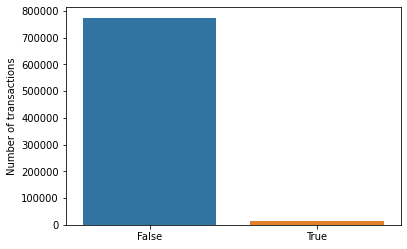

In [ ]:
fraud_notFraud = df['isFraud'].value_counts()
sns.barplot(x=[0,1], y=fraud_notFraud)
plt.xticks(ticks=[0,1], labels=['False', 'True'])
plt.ylabel('Number of transactions')

The dataset is imbalanced with approximately 98% transaction being non-fraud which is good but to build a classification model, we need to either under sample or over sample the dataset.

In [ ]:
print("Fraud percentage: {:.2f}%".format(len(df[df['isFraud']==True])/len(df)*100))
print("Non Fraud percentage: {:.2f}%".format(len(df[df['isFraud']==False])/len(df)*100))

Fraud percentage: 1.58%
Non Fraud percentage: 98.42%


Exploring other variables and their frequencies

In [ ]:
df.expirationDateKeyInMatch.value_counts()

False    785320
True       1043
Name: expirationDateKeyInMatch, dtype: int64

In [ ]:
df.acqCountry.value_counts()

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

Around 99% of transactions have US as their acquisition country.

In [ ]:
df.merchantCountryCode.value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

In [ ]:
df.posConditionCode.value_counts()

01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64

In [ ]:
df.transactionType.value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

In [ ]:
#Exploring transaction amount
df['transactionAmount'].describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5ea828210>]],
      dtype=object)

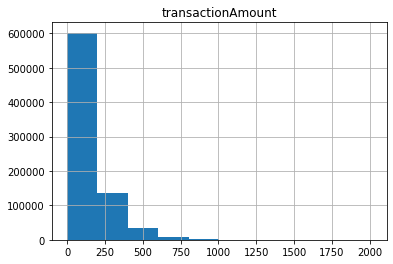

In [ ]:
df.hist(column='transactionAmount')

The transaction amount is right skewed and 75% of the transaction amounts are less than 191. 

Text(0.5, 1.0, 'Transaction Amount')

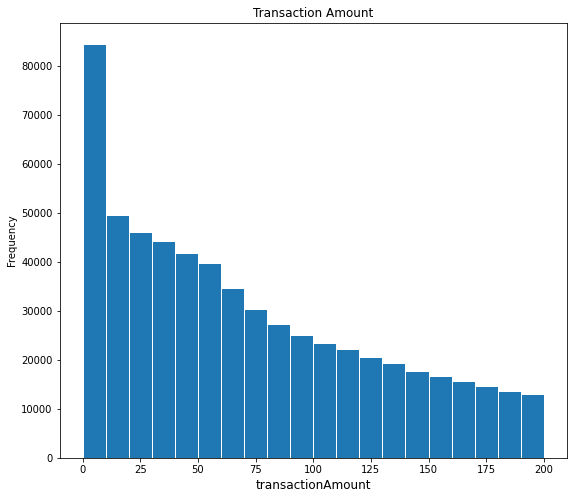

In [ ]:
#Analysing it further
plt.subplot(1,2,1)
price_data = df.loc[df['transactionAmount'] < 200]
price_data['transactionAmount'].plot.hist(bins = 20, figsize = (20,8), edgecolor = 'white')
plt.xlabel('transactionAmount', fontsize=12)
plt.title('Transaction Amount', fontsize=12)

Around 84000 transaction amounts are less than or equal to $10

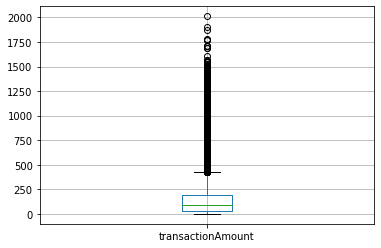

In [ ]:
df.boxplot(column='transactionAmount')

The transaction amount has so many outliers

Text(0.5, 1.0, 'Transaction Amount vs Credit Limit')

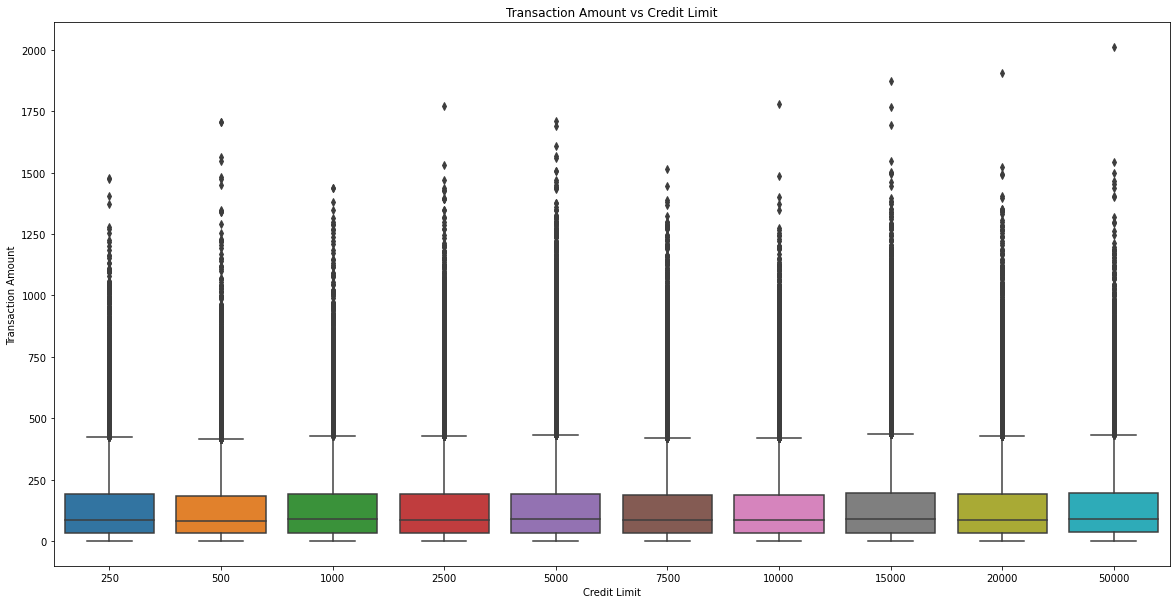

In [ ]:
#Analyzing credit limit vs transaction amount
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='creditLimit', y='transactionAmount')
plt.xlabel('Credit Limit')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount vs Credit Limit')

In [ ]:
len(df[df['creditLimit']>=5000].groupby('customerId'))/len(df['customerId'].unique())*100

75.24

Despite more than 75% customers having credit limit greater than 5000, the highest transaction amount is just 2011 overall. People are not making big purchases with their credit cards in a single transaction.

In [ ]:
#making copy of a dataframe to further analyze the data and add or delete columns.
df_copy = df.copy()

In [ ]:
df_copy['transactionDateTime'] = pd.to_datetime(df_copy.transactionDateTime) #converting transactionDateTime to pandas datetime format
df_copy.sort_values(['customerId', 'transactionDateTime'], inplace=True, ignore_index=True) #sorting the rows based on customerID and transactionDateTime

m1 = df_copy.groupby('customerId', sort=False)['transactionAmount'].apply(lambda x: x.duplicated()) #finding duplicate transaction amount
m2 = df_copy.groupby('customerId', sort=False)['transactionDateTime'].diff() <= pd.Timedelta(2, unit='minutes') #finding the transactions that occured within 2 mins of timeframe.

df_copy['multiSwiped'] = np.where(m1 & m2, True, False)

In [ ]:
len(df_copy[df_copy['multiSwiped']==True])

10982

In [ ]:
df_copy[df_copy['multiSwiped']==True]['transactionAmount'].sum()

1472873.8

We can see that 10982 transactions with an amount of 1472873.8 have occured within 2 minutes of timeframe which can be considered as multi-swipe transaction.

In [ ]:
df_copy[df_copy['multiSwiped']==True]['isFraud'].value_counts()

False    10798
True       184
Name: isFraud, dtype: int64

In [ ]:
df_copy[(df_copy['multiSwiped']==True) & (df_copy['isFraud']==True)]['transactionAmount'].sum()

39571.99

A total of 184 multi-swiped transactions, approximately 1.7% of all multi-swiped transaction are reported to be fraud amounting to 39571.9 which is 37% of the sum of all multi-swiped transactions. 

In [ ]:
df_copy['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

In [ ]:
r1 = df_copy.groupby('customerId', sort=False)['transactionAmount'].apply(lambda x: x.duplicated())
r2 = df_copy.groupby('customerId', sort=False)['transactionDateTime'].diff() <= pd.Timedelta(30, unit='days')
r3 = df_copy.groupby('customerId', sort=False)['transactionType'].apply(lambda x: x=="REVERSAL")
r4 = df_copy.groupby('customerId', sort=False)['merchantName'].apply(lambda x: x.duplicated())

df_copy['Reversed'] = np.where(r1 & r2 & r3 & r4, True, False)

Assumption: Reversal transactions with same amount as purchase, within span of 30 days, from the same merchant are being considered as duplicate transactions. Same amount from same merchant is considered because sometimes we get cashbacks from same merchants which may be of different amount.

In [ ]:
#total number of reversed transaction
len(df_copy[df_copy['Reversed']==True])

18434

In [ ]:
#sum of transaction amounts of reversed transaction
df_copy[df_copy['Reversed']==True]['transactionAmount'].sum()

2673783.57

In [ ]:
#No of fraud and non-fraud of reversed transaction
df_copy[df_copy['Reversed']==True]['isFraud'].value_counts()

False    18124
True       310
Name: isFraud, dtype: int64

In [ ]:
df_copy[(df_copy['Reversed']==True) & (df_copy['isFraud']==True)]['transactionAmount'].sum()

73556.73

Out of 18434 reversed transactions, 310 are reported to be fraud amounting to $73556 which is 37% of total transaction amount of reversed transaction.

In [ ]:
#pd. set_option('display.max_rows', None)
#df_copy.loc[(df_copy['transactionType']=="PURCHASE") & (df_copy['accountNumber']==574788567)]

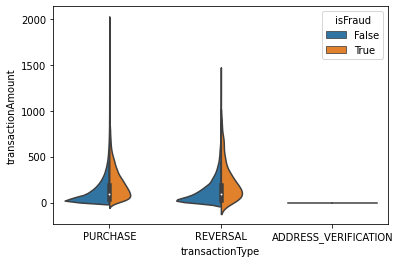

In [ ]:
sns.violinplot(data=df_copy, y='transactionAmount', x='transactionType', hue='isFraud', split=True)

From the above plot we can see that purchase transaction types are usually of large transaction amounts. Fraudsters want to spend large amount for sure.

In [ ]:
#preparing data for modelling.
#combining two columns into one by comparing values of both columns. If they match it's True else False.
df_copy['cvvMatch'] = df_copy['cardCVV'] == df_copy['enteredCVV']

In [ ]:
#Converting boolean values to 0 and 1
for col in ['cardPresent', 'cvvMatch', 'expirationDateKeyInMatch', 'isFraud', 'multiSwiped', 'Reversed']:
    df_copy[col] = df_copy[col].replace({False: 0, True: 1})

In [ ]:
#checking the correlation between isFraud and other variables. Absolute values of correlation more closer to higher is the correlation.
df_copy.corr()['isFraud']

accountNumber              -0.004011
customerId                 -0.004011
creditLimit                 0.003108
availableMoney             -0.001538
transactionAmount           0.075651
cardCVV                     0.008652
enteredCVV                  0.008655
cardLast4Digits             0.000886
currentBalance              0.007715
cardPresent                -0.043418
expirationDateKeyInMatch   -0.000972
isFraud                     1.000000
multiSwiped                 0.000921
Reversed                    0.001276
cvvMatch                   -0.010006
Name: isFraud, dtype: float64

In [ ]:
#dropping the columns which are not requied for model.
df_copy.drop(['multiSwiped', 'Reversed', 'customerId', 'enteredCVV', 'cardCVV', 'cardLast4Digits', 'merchantName', 'transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'accountNumber'], inplace=True, axis=1)

In [ ]:
#Checking for null values.
df_copy.isnull().sum()

creditLimit                    0
availableMoney                 0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
cvvMatch                       0
dtype: int64

In [ ]:
#replacing the null values of columns with the most frequent occuring value of the column.
df_copy['acqCountry'] = df['acqCountry'].fillna(df['acqCountry'].value_counts().index[0])
df_copy['merchantCountryCode'] = df['merchantCountryCode'].fillna(df['merchantCountryCode'].value_counts().index[0])
df_copy['posEntryMode'] = df['posEntryMode'].fillna(df['posEntryMode'].value_counts().index[0])
df_copy['posConditionCode'] = df['posConditionCode'].fillna(df['posConditionCode'].value_counts().index[0])
df_copy['transactionType'] = df['transactionType'].fillna(df['transactionType'].value_counts().index[0])

In [ ]:
#undersampling the majority class to balance the target variable classes.
undersample = RandomUnderSampler(sampling_strategy='majority')
y = df_copy['isFraud']
df_copy.drop('isFraud', inplace=True, axis=1)
x_underSampled, y_underSampled = undersample.fit_resample(df_copy, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Before undersampling: ", df_copy.shape)
print("After undersampling: ", x_underSampled.shape)

Before undersampling:  (786363, 13)
After undersampling:  (24834, 13)


In [ ]:
#splitting the dataset into train and test sets.
x_train, x_test, y_train, y_test = train_test_split(x_underSampled, y_underSampled, train_size=0.8, random_state=0)

In [ ]:
#converting x_train and x_test to dataframe
cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'cvvMatch']
x_train = pd.DataFrame(x_train, columns = cols)
x_test = pd.DataFrame(x_test, columns = cols)

In [ ]:
#function to encode the categorical variables.
def encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [ ]:
#encoding x_train set
features_to_encode = ['acqCountry', 'merchantCountryCode', 'merchantCategoryCode', 'transactionType']
for feature in features_to_encode:
     x_train = encode(x_train, feature)
     x_test = encode(x_test, feature)
     #x_train=res.copy()

In [ ]:
#encoding x_test set
features_to_encode = ['acqCountry', 'merchantCountryCode', 'merchantCategoryCode', 'transactionType']
for feature in features_to_encode:
     res = encode(x_test, feature)
     x_test=res.copy()

In [ ]:
#function to train a decision tree classfier
def decisiontreeclassifier(x_train, y_train, x_test, y_test):
  parameters = {
            'max_depth': [3, 5, 7],
            'min_samples_leaf': [1, 3, 5, 7],
            'max_leaf_nodes': [None, 3, 5, 7]
        }
  DC_clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv=5, verbose=0)
  DC_clf.fit(x_train, y_train)
  y_pred = DC_clf.predict(x_test)
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("F1 Score: ",f1_score(y_test, y_pred))
  print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
  print("classification report: \n",classification_report(y_test, y_pred))

In [ ]:
decisiontreeclassifier(x_train, y_train, x_test, y_test)

Accuracy:  0.6623716529092007
F1 Score:  0.6405144694533761
Confusion matrix: 
 [[1796  688]
 [ 989 1494]]
classification report: 
               precision    recall  f1-score   support

           0       0.64      0.72      0.68      2484
           1       0.68      0.60      0.64      2483

    accuracy                           0.66      4967
   macro avg       0.66      0.66      0.66      4967
weighted avg       0.66      0.66      0.66      4967



Accuracy of 66% isn't that good. The model is able to identify 68% of fraudulent transaction but also it has flagged 60% non-fraud transaction as fraud. We need to have high precision and high recall which will be challenging because we don't want to miss on fraud transactions and also we don't want to flag non-fraud transactions as fraud, which is where f1 score is useful because it is the harmonic mean of precision and recall.

In [ ]:
#function to train classification model using XGBoost
def xgbclassifier(x_train, y_train, x_test, y_test):
  estimator = XGBClassifier(tree_method = "hist", n_jobs=-1)
  parameters = {
    'max_depth': range (1, 3, 5),
    'n_estimators': range(10, 60, 100),
    'learning_rate': [0.001, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.5, 0.7, 0.9],
    'reg_alpha': [0.01, 0.05, 0.07, 0.09, 0.5, 1],
    'reg_lambda': [0.01, 0.05, 0.07, 0.09, 0.5, 1] }
  xgb_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=5, verbose=0)
  xgb_clf.fit(x_train, y_train)
  y_pred = xgb_clf.predict(x_test)
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("F1 Score: ",f1_score(y_test, y_pred))
  print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
  print("classification report: \n",classification_report(y_test, y_pred))

In [ ]:
#converting object datatypes to int
x_train['creditLimit'] = x_train.creditLimit.astype(int)
x_train['availableMoney'] = x_train.availableMoney.astype(int)
x_train['transactionAmount'] = x_train.transactionAmount.astype(int)
x_train['posEntryMode'] = x_train.posEntryMode.astype(int)
x_train['posConditionCode'] = x_train.posConditionCode.astype(int)
x_train['currentBalance'] = x_train.currentBalance.astype(int)
x_train['cardPresent'] = x_train.cardPresent.astype(int)
x_train['expirationDateKeyInMatch'] = x_train.expirationDateKeyInMatch.astype(int)
x_train['cvvMatch'] = x_train.cvvMatch.astype(int)

In [ ]:
#converting object datatypes to int
x_test['creditLimit'] = x_test.creditLimit.astype(int)
x_test['availableMoney'] = x_test.availableMoney.astype(int)
x_test['transactionAmount'] = x_test.transactionAmount.astype(int)
x_test['posEntryMode'] = x_test.posEntryMode.astype(int)
x_test['posConditionCode'] = x_test.posConditionCode.astype(int)
x_test['currentBalance'] = x_test.currentBalance.astype(int)
x_test['cardPresent'] = x_test.cardPresent.astype(int)
x_test['expirationDateKeyInMatch'] = x_test.expirationDateKeyInMatch.astype(int)
x_test['cvvMatch'] = x_test.cvvMatch.astype(int)

In [ ]:
xgbclassifier(x_train, y_train, x_test, y_test)

Accuracy:  0.6573384336621704
F1 Score:  0.6431865828092244
Confusion matrix: 
 [[1731  753]
 [ 949 1534]]
classification report: 
               precision    recall  f1-score   support

           0       0.65      0.70      0.67      2484
           1       0.67      0.62      0.64      2483

    accuracy                           0.66      4967
   macro avg       0.66      0.66      0.66      4967
weighted avg       0.66      0.66      0.66      4967



Little less accuracy compared to the previous model.

In [ ]:
def logisticRegression(x_train, y_train, x_test, y_test):
  parameters = {
            'penalty': ['l2', 'none'],
            'C': [0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 1, 10, 100],
            'fit_intercept': [True, False],
            'n_jobs': [-1]
        }
  log_clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=parameters, cv=5, verbose=0)
  log_clf.fit(x_train, y_train)
  y_pred = log_clf.predict(x_test)
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("F1 Score: ",f1_score(y_test, y_pred))
  print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
  print("classification report: \n",classification_report(y_test, y_pred))

In [ ]:
logisticRegression(x_train, y_train, x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and

Accuracy:  0.6301590497282061
F1 Score:  0.5795376516365301
Confusion matrix: 
 [[1864  620]
 [1217 1266]]
classification report: 
               precision    recall  f1-score   support

           0       0.60      0.75      0.67      2484
           1       0.67      0.51      0.58      2483

    accuracy                           0.63      4967
   macro avg       0.64      0.63      0.62      4967
weighted avg       0.64      0.63      0.62      4967



Better precision and recall for fraud class but overall accuracy and f1-score degraded.

In [ ]:
def RFClassifier(x_train, y_train, x_test, y_test):
  parameters = {
            'n_estimators': [10, 50, 100],
            'max_depth': [5],
            'bootstrap': [True, False],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 5],
            'oob_score': [True, False]
        }
  RF_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=5, verbose=0)
  RF_clf.fit(x_train, y_train)
  y_pred = RF_clf.predict(x_test)
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("F1 Score: ",f1_score(y_test, y_pred))
  print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
  print("classification report: \n",classification_report(y_test, y_pred))


In [ ]:
RFClassifier(x_train, y_train, x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

Accuracy:  0.6645862693778941
F1 Score:  0.6492631578947369
Confusion matrix: 
 [[1759  725]
 [ 941 1542]]
classification report: 
               precision    recall  f1-score   support

           0       0.65      0.71      0.68      2484
           1       0.68      0.62      0.65      2483

    accuracy                           0.66      4967
   macro avg       0.67      0.66      0.66      4967
weighted avg       0.67      0.66      0.66      4967



Random Forest has shown slight increase in accuracy and f1 score compared to decision tree classifier. The model can be tuned further to find best possible parameters combination to increase the accuracy.

* Out of all models decision tree classifier has an accuracy of 66% which is 
highest. 
**Improvements and things to do next if more time is given** 
(Due to time constraint, academic projects, assignments and mid-term exam)
* The models can be further improved by analyzing the each variable in more detailed way and by determining their contribution in determining the target variable i.e., isFraud. We can find each customers' go to merchants and try to flag as and when we find other customers. Analysis can be detailed down to mercahnt country and acquisition country match.
* We can improve the analysis by including more plots and graphs i.e., by visualisation.
* We can try some more models such as SVM, Kmeans to classify.
* The models are not performing up to mark because of the imbalanced dataset.
* We can plot ROC curve for all the models to find the best performing model.
* We can try to collect more variables that might be helpful, such as an IP address of the customer can help us in flagging the fraud transactions.
* More clarity on POSEntryMode and POSConditionCode would have been helpful.
* Tried oversampling the minority class, but the results were worse than the undersampling.
* Further finetuning of model hyperparameters can be done to increase the accuracy of the models.
* The code can be modularized if given more time by defining more functions and implementing OOP by reducing the repetition of code.
